In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from nltk.corpus import stopwords

import re
from collections import defaultdict
from nltk.corpus import wordnet as wn

from nltk.stem import WordNetLemmatizer, PorterStemmer

from nltk import pos_tag

import gensim.downloader as api

from sklearn import model_selection

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report

import pickle

In [2]:
df = pd.read_csv('DB/Sentence1.csv')

In [3]:
df.head(10)

,Sentence,Symptom
0,"I feel a sharp, burning sensation when I urinate.",Burning Micturition
1,It feels like my bladder is on fire every time...,Burning Micturition
2,I can't help but flinch because of the intense...,Burning Micturition
3,My urine feels so hot and painful that I dread...,Burning Micturition
4,"There's a stinging, uncomfortable feeling that...",Burning Micturition
5,"Every time I try to urinate, it feels like my ...",Burning Micturition
6,It's an unbearable pain at the end of my urina...,Burning Micturition
7,"The burning sensation is constant, and it only...",Burning Micturition
8,"When I pee, there's this heat that makes me wa...",Burning Micturition
9,It feels like I have a urinary tract infection...,Burning Micturition


In [4]:
df.size

760

In [5]:
df.describe()

,Sentence,Symptom
count,380,380
unique,380,18
top,"I feel a sharp, burning sensation when I urinate.",Burning Micturition
freq,1,30


In [6]:
type(df)

pandas.core.frame.DataFrame

In [7]:
#df = pd.DataFrame(df)

In [8]:
df['Sentence'] = [entry.lower() for entry in df['Sentence']]

In [9]:
df.head()

,Sentence,Symptom
0,"i feel a sharp, burning sensation when i urinate.",Burning Micturition
1,it feels like my bladder is on fire every time...,Burning Micturition
2,i can't help but flinch because of the intense...,Burning Micturition
3,my urine feels so hot and painful that i dread...,Burning Micturition
4,"there's a stinging, uncomfortable feeling that...",Burning Micturition


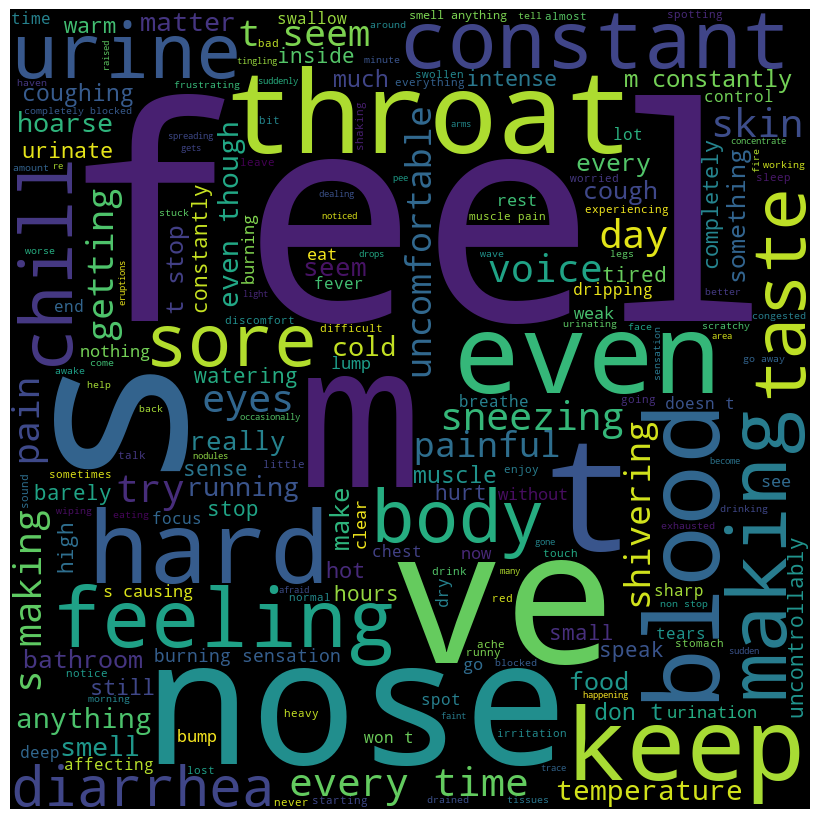

In [10]:
text = " ".join(review for review in df['Sentence'])
wordcloud = WordCloud(width=800, height=800, min_font_size=8).generate(text)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [11]:
custom_stopwords = set(stopwords.words('english')).union({'doctor', 'feel', 'feeling', 'experience', 'experiencing', 'sensation', 'really', 'get', 'got', 'just'})

In [12]:
def preprocess_sentence(sentence):

    sentence = re.sub(r'[^a-zA\s]', '', sentence)

    tokens = sentence.split()

    tag_map = defaultdict(lambda: wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    lematizer = WordNetLemmatizer() 
    stemmer = PorterStemmer()

    final_word = []

    for word, tag in pos_tag(tokens):

        if word not in custom_stopwords and word.isalpha():

            word_lematized = lematizer.lemmatize(word, tag_map[tag[0]])
            word_stemmed = stemmer.stem(word_lematized)
            final_word.append(word_stemmed)

    return " ".join(final_word)
    

In [13]:
df['cleaned_text'] = df['Sentence'].apply(preprocess_sentence)

glove_vectors = api.load("glove-wiki-gigaword-100")

def get_word_embeddings(sentence):
    words = sentence.split()

    embeddings = [glove_vectors[word] for word in words if word in glove_vectors]

    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(100)

In [14]:
df['embeddings'] = df['cleaned_text'].apply(get_word_embeddings)

df = df[df['embeddings'].apply(lambda x:x.sum() != 0)]

In [15]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['embeddings'].tolist(), df['Symptom'], test_size=0.2, random_state=0)

encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.transform(test_y)

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [16]:
# fgind the best hyperparameters for the SVM model by tring out different combination of 'c' and 'kernel'ArithmeticError

param_gris = {'C' : [0.1, 1, 10, 10, 100], 'kernel' : ['linear', 'rbf']}
grid = GridSearchCV(SVC(), param_gris, refit=True, verbose=2)
grid.fit(train_x, train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, k

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 10, 100],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [17]:
# get the best combination of hyperparameters that resulted in the highest performance on the training data.
# Best estimator
print(f"Best parameters found: {grid.best_params_}")
classifier = grid.best_estimator_

Best parameters found: {'C': 10, 'kernel': 'rbf'}


In [18]:
# Making predictions
predictions = classifier.predict(test_x)

In [19]:
predictions

array([17, 10,  1,  1, 15,  1,  7,  1,  0, 16,  1, 11, 15,  2,  7, 16,  7,
       14, 16, 10, 11,  0,  4,  9,  2, 17, 13,  3,  6, 15, 11, 11,  1,  2,
       16,  8, 17,  2, 11,  4, 11, 11, 12,  9, 10, 13,  3,  1, 16,  4,  6,
        6, 12,  1,  3,  0, 10,  8,  2,  1, 14,  4,  6,  7, 12,  3,  8,  3,
        1,  5,  7, 10,  8,  6,  5, 16])

In [20]:
# Evaluate the model
print("Accuracy Score: ", accuracy_score(test_y, predictions))
print("Classification Report: \n", classification_report(test_y, predictions, target_names=encoder.classes_))

Accuracy Score:  0.5921052631578947
Classification Report: 
                       precision    recall  f1-score   support

        Blocked Nose       1.00      0.75      0.86         4
 Burning Micturition       0.40      0.50      0.44         8
              Chills       0.60      1.00      0.75         3
 Continuous Sneezing       0.00      0.00      0.00         0
               Cough       0.75      0.60      0.67         5
            Diarrhea       1.00      0.67      0.80         3
       Feeling Tired       0.20      0.25      0.22         4
    High Temperature       0.60      0.60      0.60         5
        Hoarse Voice       0.75      0.43      0.55         7
       Loss of Smell       1.00      1.00      1.00         2
       Loss of Taste       1.00      0.56      0.71         9
         Muscle Pain       0.29      0.50      0.36         4
Nodal Skin Eruptions       1.00      0.43      0.60         7
          Runny Nose       0.50      1.00      0.67         1
        

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [21]:
with open('Model/svm_model.pkl', 'wb') as file:
    pickle.dump(classifier, file)

with open('Model/label_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

with open('Model/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [22]:
# Load the trained model from the pickle file
with open('Model/svm_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Load the Label Encoder (if saved)
with open('Model/label_encoder.pkl', 'rb') as file:
    loaded_encoder = pickle.load(file)

# Load the Scaler (if saved)
with open('Model/scaler.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)

In [23]:
def predict_symptom(sentence):
    preprocesses_sentence = preprocess_sentence(sentence)
    embeddings = get_word_embeddings(preprocesses_sentence)
    embeddings = scaler.transform([embeddings])
    prediction = classifier.predict(embeddings)
    predicted_label = loaded_encoder.inverse_transform(prediction)
    return predicted_label[0]

In [24]:
sample_sentences = ["I'm concerned about this rash because it's causing me discomfort", "no","I have these strange knots on my skin that are causing me a lot of pain.","I'm experiencing terrible stomach pain, and I don't know what's wrong.","I've been experiencing acid reflux, and it's really uncomfortable.", "What", "stomach pain", "vomit"]
#nodal skin eruptions
#stomach pain
#acidity

In [25]:
for i in sample_sentences:
    print(predict_symptom(i))

Burning Micturition
Loss of Taste
Sore Throat
Burning Micturition
Continuous Sneezing
Continuous Sneezing
Burning Micturition
Continuous Sneezing
